## Product Analytics and Recommendation Systems

Understanding how customers engage and interact with the different products is crucial for various companies, especially among e-commerce. This type of analysis can help businesses improve user engagement and conversions and, therefore, profits.

In this analysis, I'm going to explore some basics of product analytics and dive deeper into building product recommendation systems. 

![](https://www.lux-review.com/wp-content/uploads/2020/12/grocery-shopping.jpg)

## Data Preparation

[Online Retail Data](https://www.kaggle.com/vijayuv/onlineretail) is a great data set for product analysis. So now I'm going to start with importing data and loading the necessary R libraries. 

In [1]:
library(dplyr)
library(ggplot2)
library(lubridate)
library(reshape2)
library(coop)

data <- read.csv("../input/onlineretail/OnlineRetail.csv")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Here are some negative quantities because of the canceled or refunded orders. I will remove them from the data set. Also, I will convert InvoiceDate to a date format. 

In [2]:
#filtering out negative quantities
data <- data %>%
  filter(Quantity > 0)

#changing to date format and extracting date
data$InvoiceDate=as.POSIXct(data$InvoiceDate,
                            format="%m/%d/%Y %H:%M",
                            tz=Sys.timezone())
data$InvoiceDate <-date(data$InvoiceDate)

## Time Series Analysis

Before looking at the product-level data, I will explore overall time series trends in the revenue and the number of orders to understand whether the business is growing or shrinking over time. 

First, let's look at the number of orders over time.

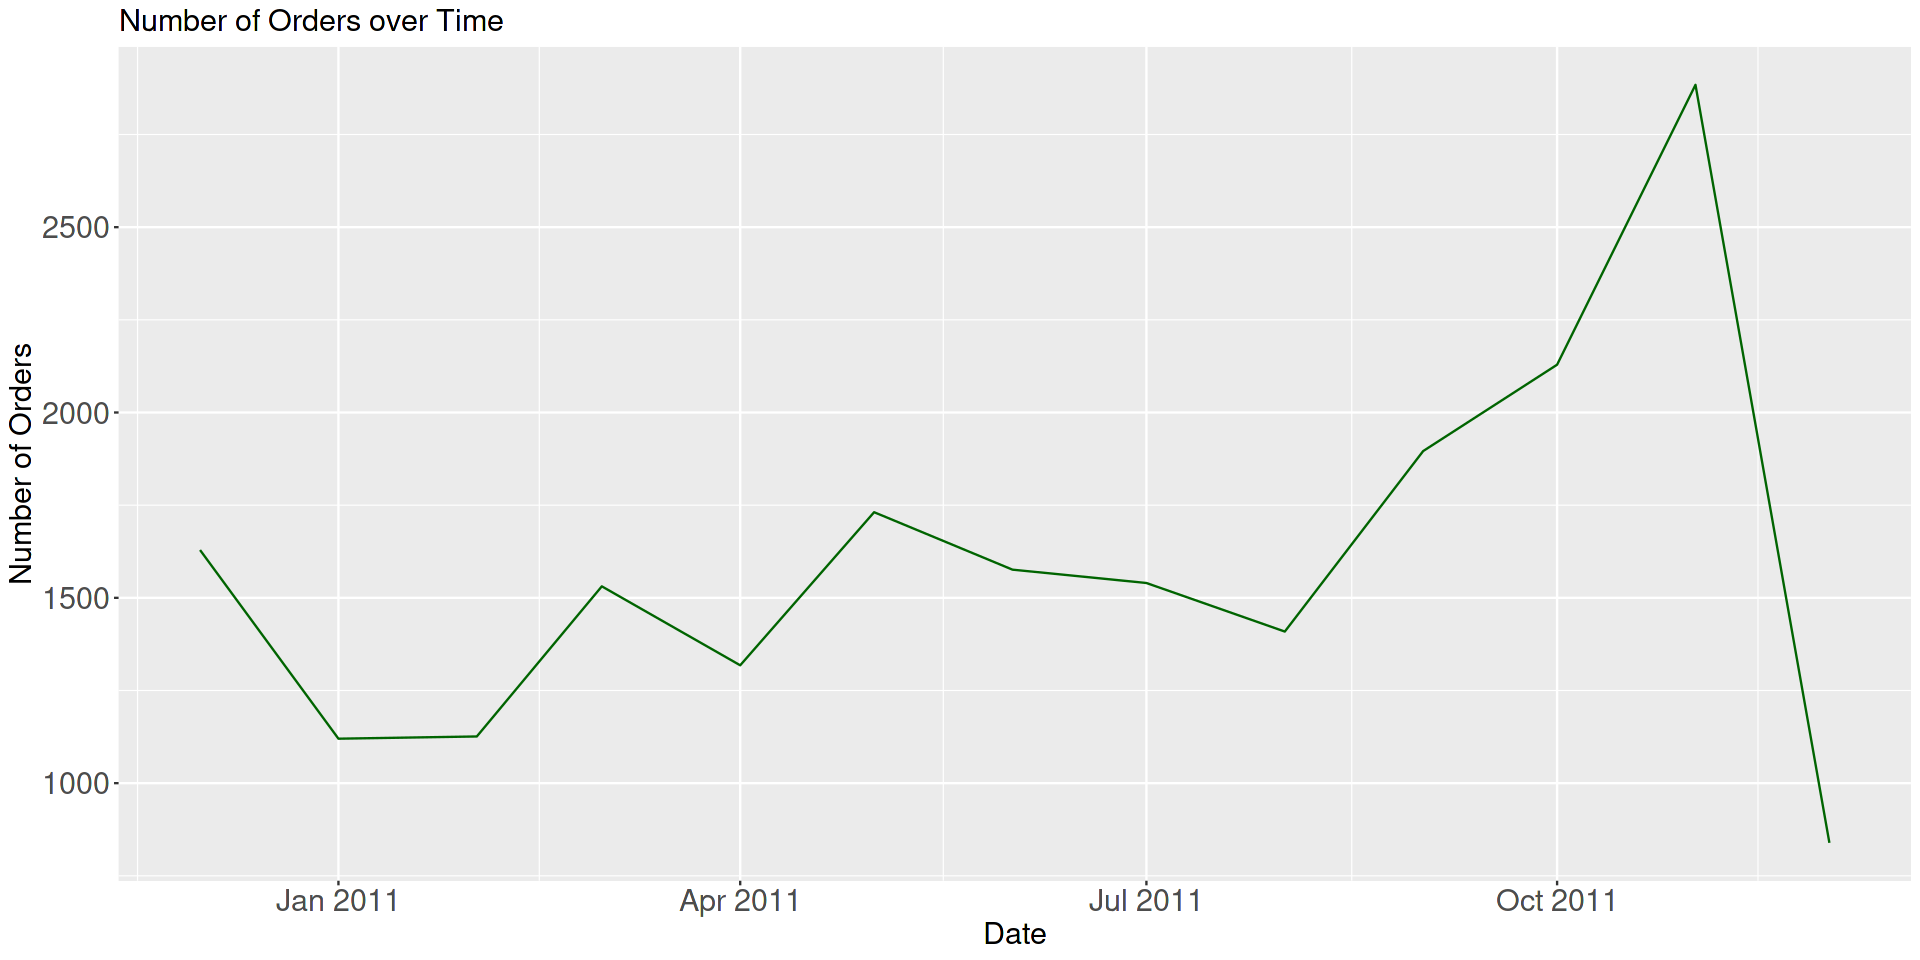

In [3]:
NumInvoices <- data %>%
  group_by(InvoiceDate=floor_date(InvoiceDate, "month")) %>%
  summarise(NumOrders=n_distinct(InvoiceNo))

options(repr.plot.width = 16, repr.plot.height = 8)
ggplot(NumInvoices, aes(x=InvoiceDate, y=NumOrders)) +
  geom_line(color="darkgreen") +
  labs(title="Number of Orders over Time") +
  ylab("Number of Orders")+
  xlab("Date")+
  theme(axis.text.x = element_text(size=18),axis.text.y = element_text(size=18), 
        axis.title = element_text(size = 18), plot.title = element_text(size=18))

Oops, what is this sudden drop in the number of orders in December 2011?
Fortunately, this is because we only have the data from December 1 to December 9. I'm going to remove the data from December for my analysis. Otherwise, it would be a misrepresentation.

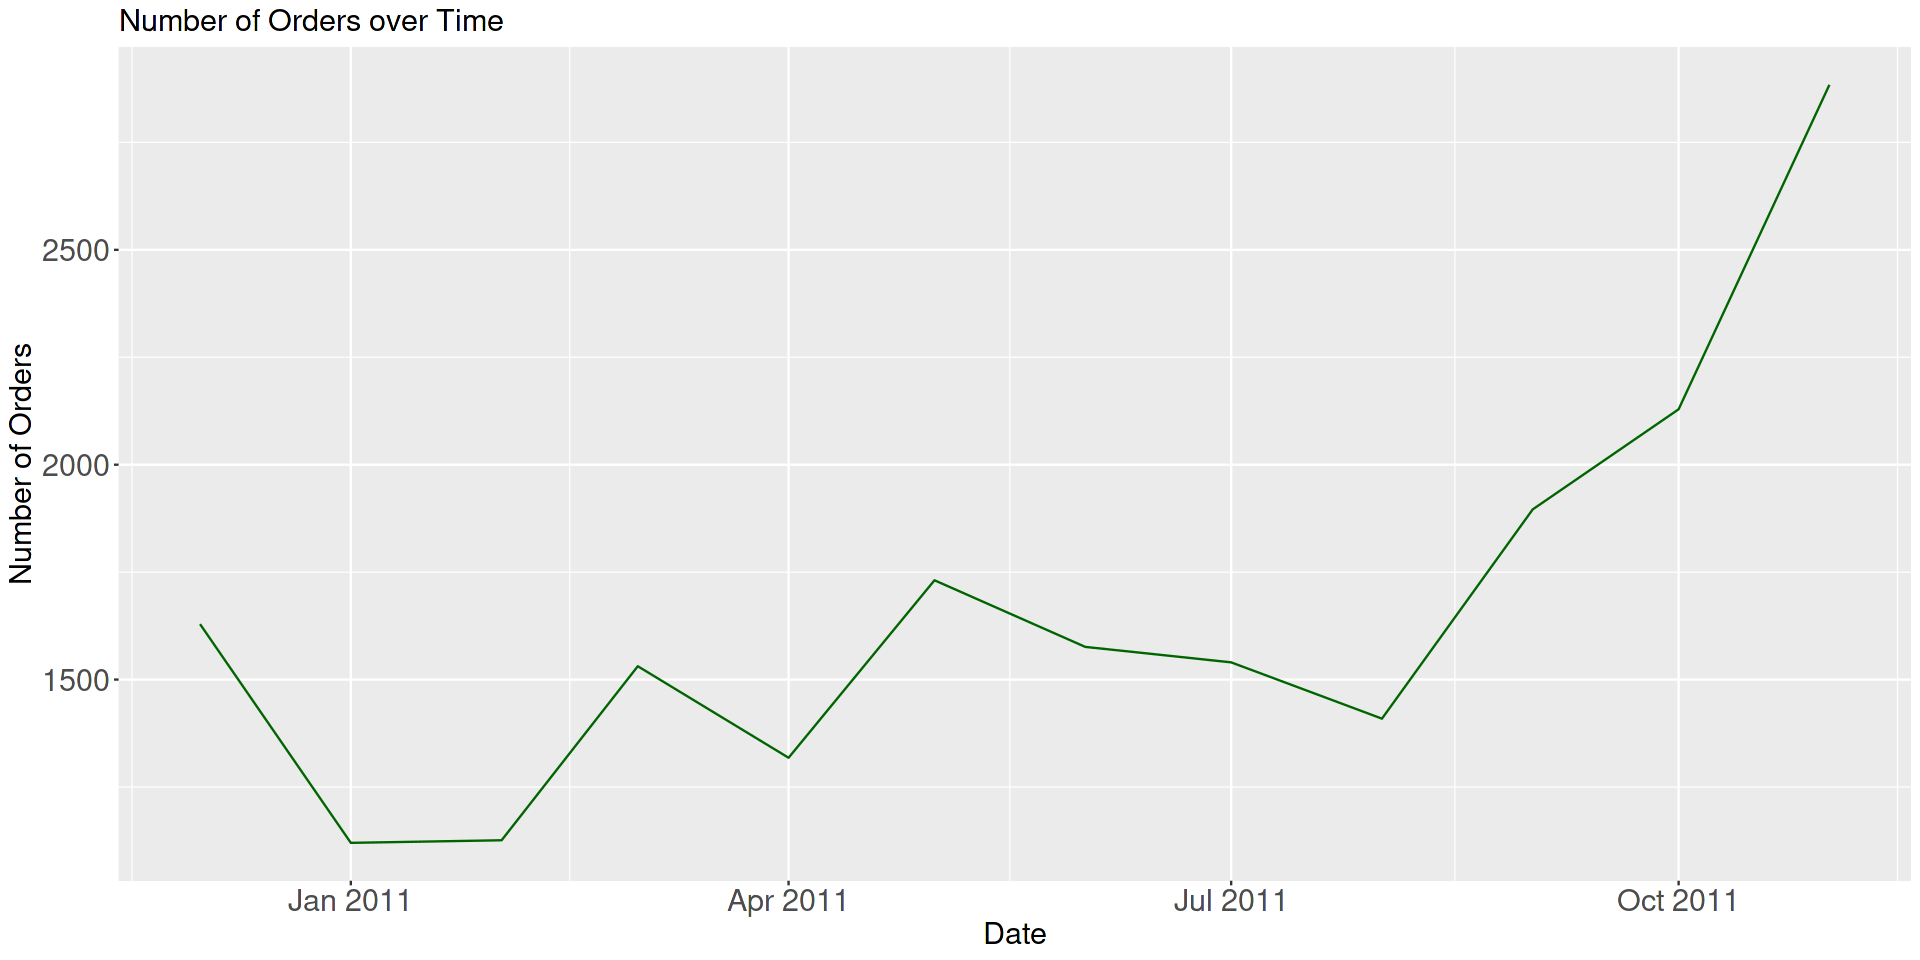

In [4]:
#removing this data from the data set
data <- data %>%
  filter(InvoiceDate < "2011-12-01")

NumInvoices <- data %>%
  group_by(InvoiceDate=floor_date(InvoiceDate, "month")) %>%
  summarise(NumOrders=n_distinct(InvoiceNo))

#plotting again
ggplot(NumInvoices, aes(x=InvoiceDate, y=NumOrders)) +
  geom_line(color="darkgreen") +
  labs(title="Number of Orders over Time") +
  ylab("Number of Orders")+
  xlab("Date")+
  theme(axis.text.x = element_text(size=18),axis.text.y = element_text(size=18), 
        axis.title = element_text(size = 18), plot.title = element_text(size=18))



We see that number of orders started to increase significantly from September 2011 and had their peak in November 2011. That could be because the business was growing or because of the seasonal effect. In this case, we really need to look at the previous years to tell more.

Let's look at the monthly sales now.

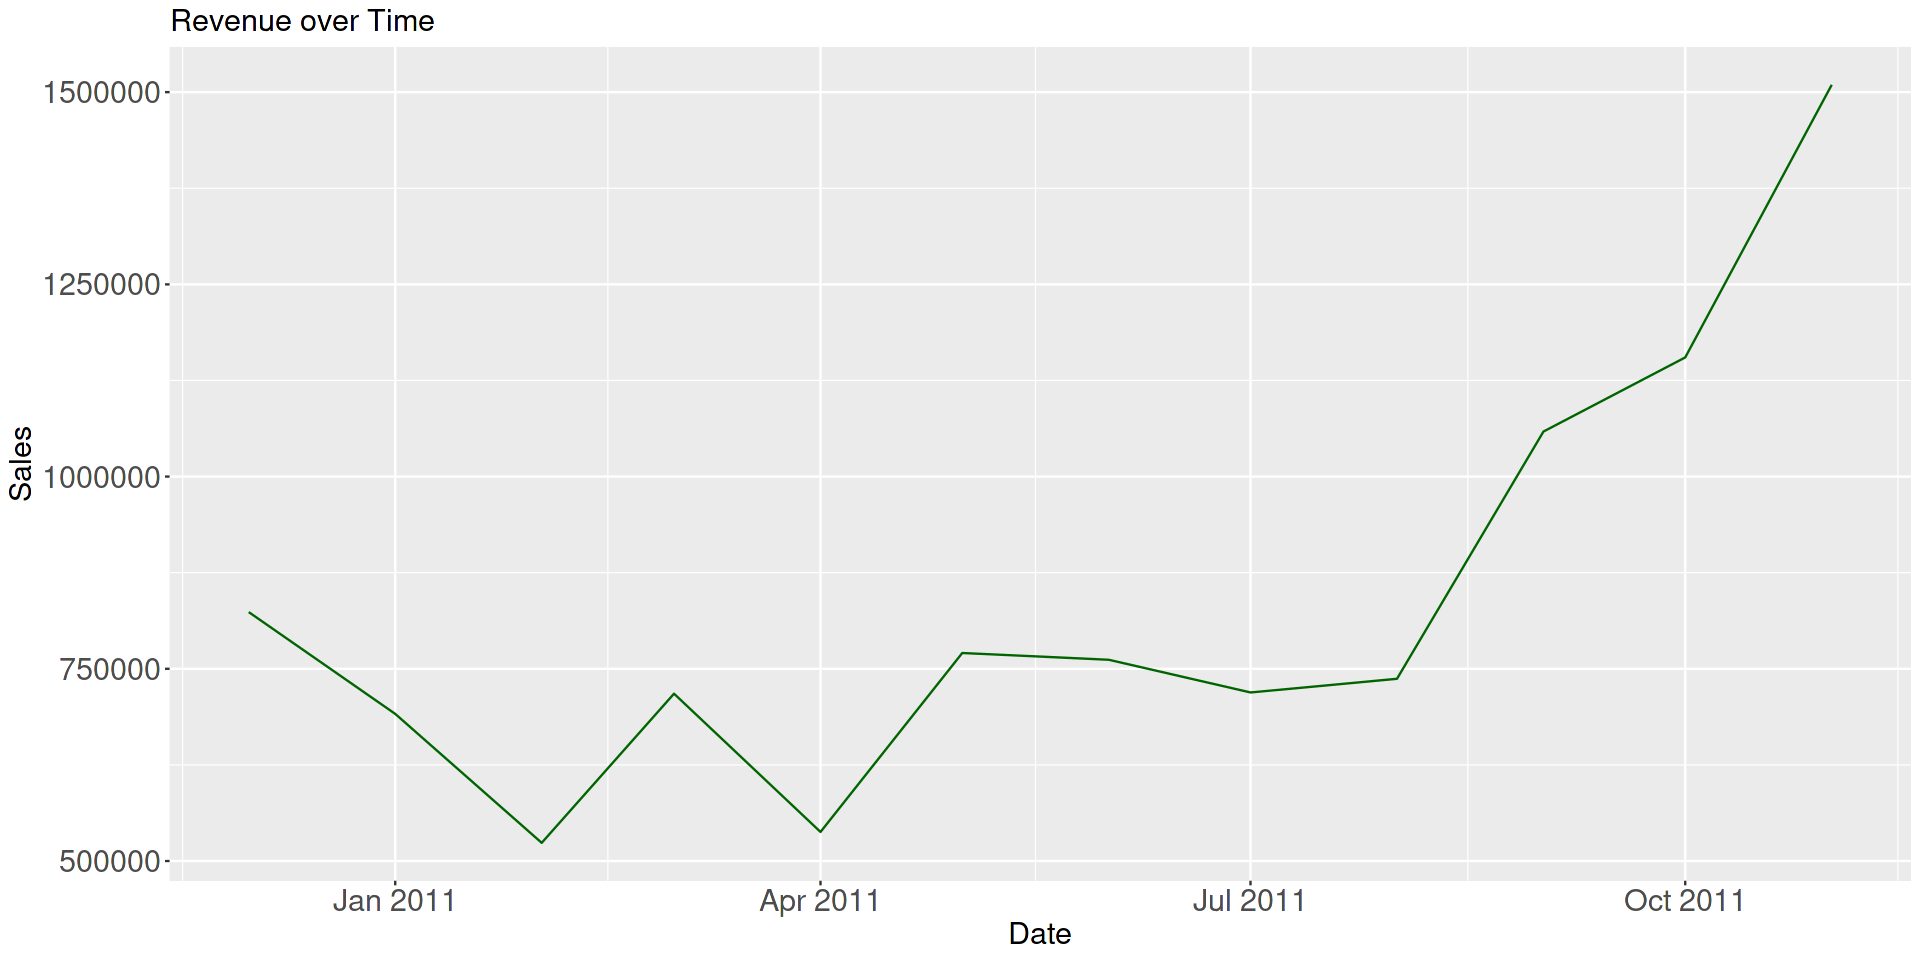

In [5]:
#calculate the sales column
data <- data %>%
  mutate(Sales=Quantity*UnitPrice)

Revenue <- data %>%
  group_by(InvoiceDate=floor_date(InvoiceDate, "month")) %>%
  summarise(Sales=sum(Sales))

ggplot(Revenue, aes(x=InvoiceDate, y=Sales)) +
  geom_line(color="darkgreen") +
  labs(title="Revenue over Time") +
  ylab("Sales")+
  xlab("Date")+
  theme(axis.text.x = element_text(size=18),axis.text.y = element_text(size=18), 
        axis.title = element_text(size = 18), plot.title = element_text(size=18))

Here we see the same pattern as with the number of orders. This orders and revenue analysis helps to understand overall business performance.

## Repeat Customers

Every successful business knows how important it is to retain customers to have a steady stream of sales from them. Let's see how many sales are from existing customers for this online retail business that I'm analyzing. 

`summarise()` has grouped output by 'InvoiceNo'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'InvoiceDate'. You can override using the `.groups` argument.



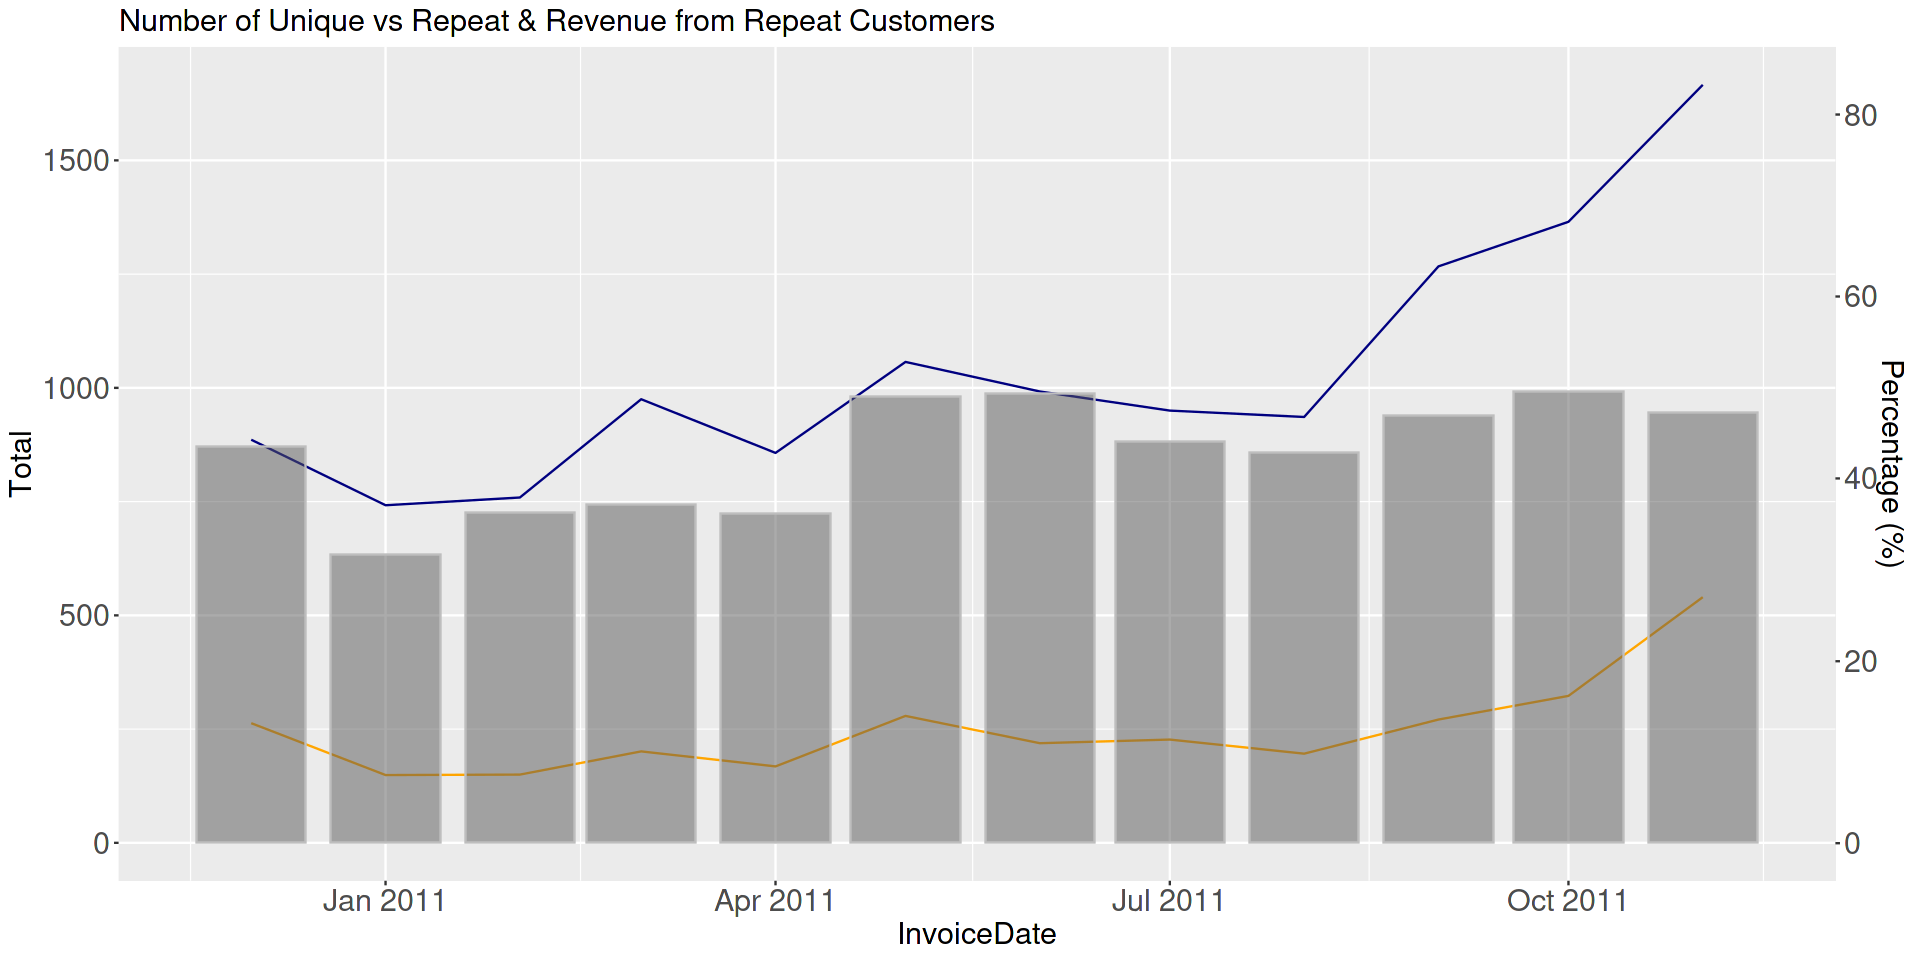

In [6]:
#aggregating data so that one row represents one purchase order
Invoice <- data %>%
  group_by(InvoiceNo, InvoiceDate) %>%
  summarize(CustomerID=max(CustomerID), Sales=sum(Sales))

#aggregating data into months
InvoiceCustomer <- Invoice %>%
  group_by(InvoiceDate=floor_date(InvoiceDate, "month"), CustomerID) %>%
  summarise(Count=n_distinct(InvoiceNo), Sales=sum(Sales))

#filter out customer with 1 order and NA CustomerId
RepeatCustomers <-InvoiceCustomer%>%
  filter(!is.na(CustomerID)) %>%
  filter(Count>1)

RepeatCustomers <- RepeatCustomers %>%
  group_by(InvoiceDate) %>%
  summarize(Count=n_distinct(CustomerID), Sales=sum(Sales))

#total number of monthly customers
UniqueCustomers <- data %>%
  group_by(InvoiceDate=floor_date(InvoiceDate, "month")) %>%
  summarise(Count=n_distinct(CustomerID))

#find the percentage of monthly revenue that are attributed to the repeat customers
RepeatCustomers$Perc <- RepeatCustomers$Sales/Revenue$Sales*100.0
#append unique customers
RepeatCustomers$Total <- UniqueCustomers$Count

#visualize repeat customers data
ggplot(RepeatCustomers) +
  geom_line(aes(x=InvoiceDate, y=Total), stat="identity", color="navy") +
  geom_line(aes(x=InvoiceDate, y=Count), stat="identity", color="orange") +
  geom_bar(aes(x=InvoiceDate, y=Perc*20), stat="identity", color="gray", alpha=0.5) +
  scale_y_continuous(sec.axis = sec_axis(~./20, name="Percentage (%)")) +
  labs(title="Number of Unique vs Repeat & Revenue from Repeat Customers") +
  theme(axis.text.x = element_text(size=18),axis.text.y = element_text(size=18), 
        axis.title = element_text(size = 18), plot.title = element_text(size=18))

**Blue line** - Number of unique (total) customers

**Yellow line** - Number of repeat customers

**Gray bars** - represent the revenue from repeat customers


We see that **repeat customers are about 20-30 %** of the total monthly customers. But **40-50% of revenue comes** from these repeat customers. Here we see a great example of why it is important to retain existing customers. 

## Trending Products

I'm going to explore hiw customers interact with company products and take a look **at the top five best-sellers** over time.

`summarise()` has grouped output by 'InvoiceDate'. You can override using the `.groups` argument.

Selecting by Quantity



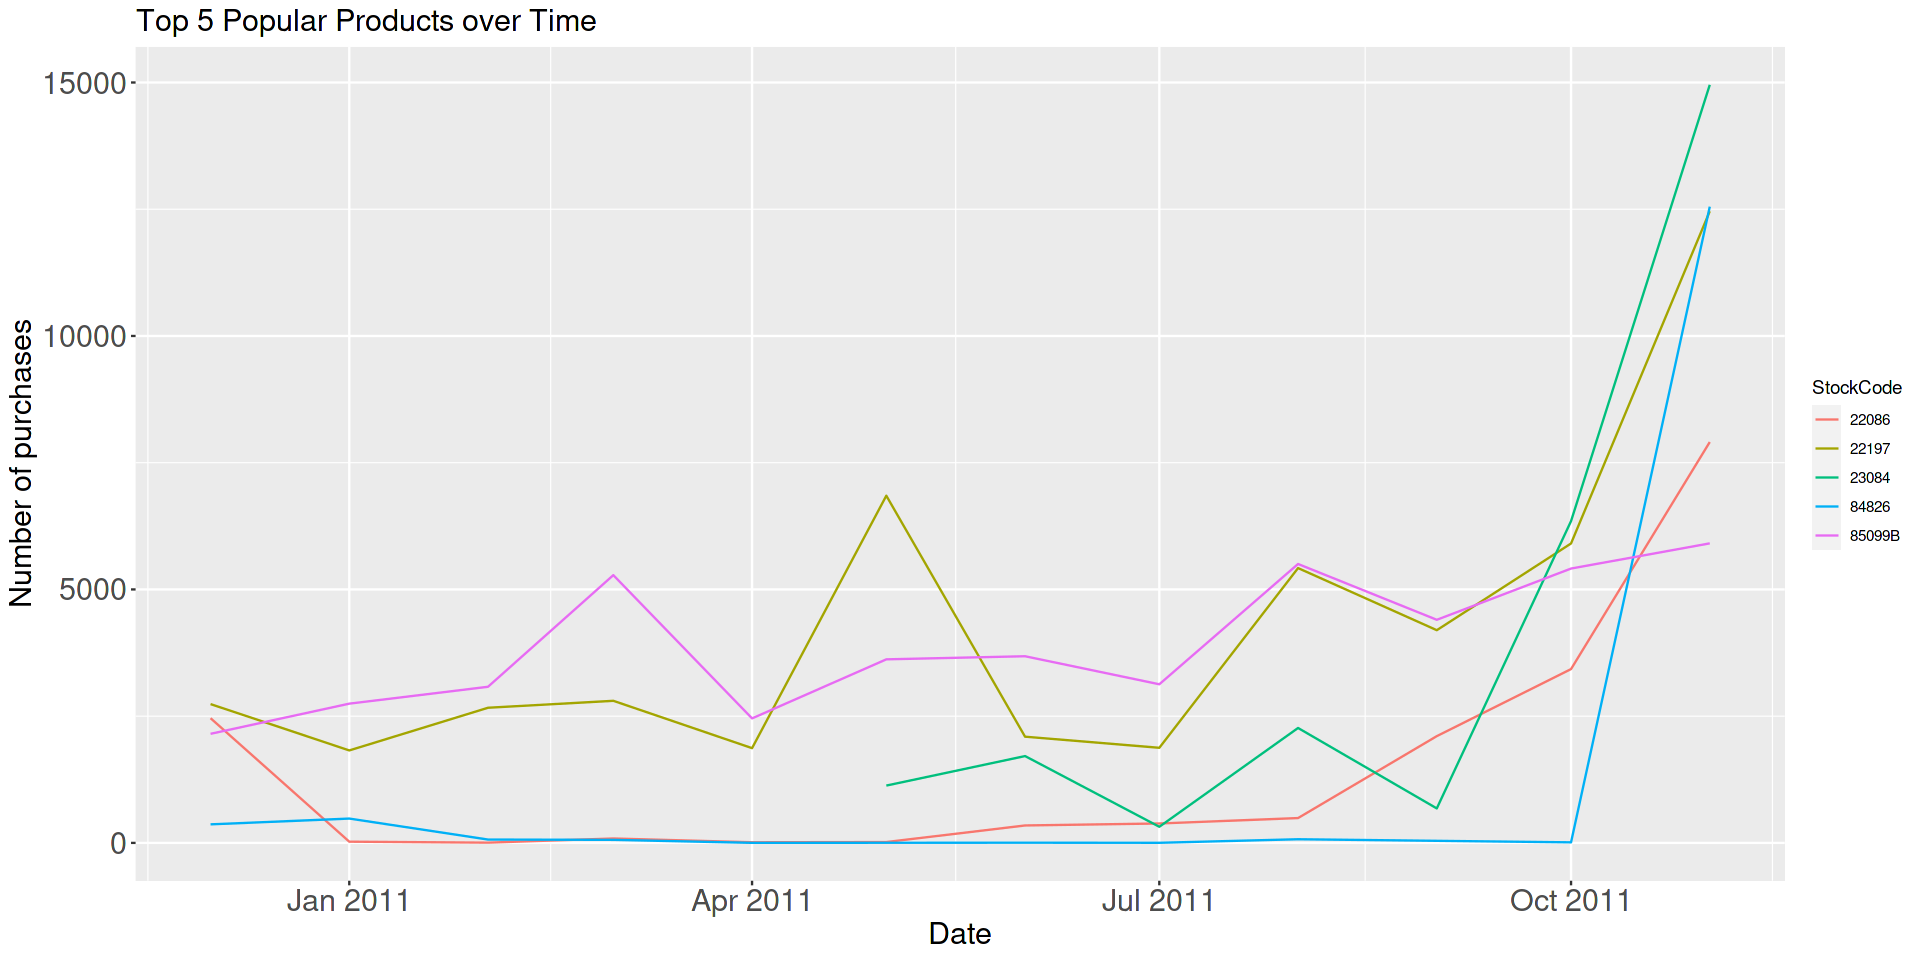

In [7]:
#number of items sold for each product for each period
PopularProducts <- data %>%
  group_by(InvoiceDate = floor_date(InvoiceDate, "month"), StockCode) %>%
  summarise(Quantity=sum(Quantity))

#let's find top 5 items sold in November 2011 (most recent trends)
Top5 <- PopularProducts %>%
  filter(InvoiceDate=="2011-11-01") %>%
  arrange(desc(Quantity)) %>%
  top_n(5)

#here we take the data from PopularProducts data frame with the stock codes in Top5
Top5monthly <- PopularProducts[
  which(PopularProducts$StockCode %in% Top5$StockCode),]

ggplot(Top5monthly, aes(x=InvoiceDate, y=Quantity, color=StockCode)) +
  geom_line() +
  labs(title="Top 5 Popular Products over Time") +
  ylab("Number of purchases")+
  xlab("Date")+
  theme(axis.text.x = element_text(size=18),axis.text.y = element_text(size=18), 
        axis.title = element_text(size = 18), plot.title = element_text(size=18))

Here we see **top-5** trending products with the stock codes **22086, 22197, 23084, 84826, and 85099B.** I can recommend these popular products in marketing emails or ads to improve engagement. New customers might be more interested in these items and more likely to purchase them. So this can help to **increase the conversion rate of your online campaigns or conversion rates of your web pages** with these products. 

## Recommending Products

Personalized product recommendations improve conversion rates and customer retention rates. Recommender systems are used in a variety of areas, with commonly recognised examples taking the form of playlist generators for video and music services, product recommenders for online stores, or content recommenders for social media platforms and open web content recommenders (sourse: [Wikipedia](https://en.wikipedia.org/wiki/Recommender_system)).

**Collaborative filtering**, which I'm going to do in this analysis, is a method to recommend products based on previous user behaviors (viewed pages, purchased products, given ratings). The idea is to find **similarities between users and products/content**, and recommend the most similar products or content. For example, if one user purchased a white t-shirt, blue jeans, and a hat and the other user purchased a white t-shirt, blue jeans, and gloves, then the first user is more likely to buy gloves and the second - a hat (because of their similarities in purchasing products).
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/0o0zVW2O6Rv-LI5Mu1.png)


Let's start with some **data preparation**.

First, I need to **handle NA values** in the CustomerID column to build a proper recommendation system. Second, I need to build **a customer-to-item matrix** which is tabular data where each column represents each product, each row represents a customer, and values in each cell represent whether a customer purchased the given product or not.

In [8]:
#handling NA values in the CustomerID field
sum(is.na(data$CustomerID))
#133 361 NA in CustomerID

#let's omit NA values
data <- na.omit(data)

#building a customer-item matrix
#reshape our data frame
CustomerItemMatxix <-dcast(data, CustomerID ~ StockCode, value.var = "Quantity")

#let's encode 0-1 where 1 means that the product was purchased (at least once)
#and 0 means that the product was never purchased by the given customer.
encode <- function(x){as.integer(x>0)}
CustomerItemMatxix <- CustomerItemMatxix %>%
  mutate_at(vars(-CustomerID), funs(encode))


[1] 125530

Aggregation function missing: defaulting to length

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


## User-based vs. Item-based collaborative filtering

I will explore two approaches to building a product recommendation system:

1. User-based approach - looking for similarities between users based on their product purchase history.

2. Item-based approach - looking for similarities between products based on which items are often bought together with other items.

Let's start with a **user-based approach.**

In [9]:
head(CustomerItemMatxix)

,CustomerID,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,⋯,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,12346,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,12347,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,12348,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
4,12349,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
5,12350,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
6,12352,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,1


This it the **customer-item matrix** that I created on the previous step. It shows whether the given customer bought (1) or not(0) the given product. What I need to do now is to compute **cosine similarities between customers** using *coop library*. 

In [10]:
#compute cosine similarities between users
UserToUser <- cosine(
  as.matrix(
    t(CustomerItemMatxix[, 2:dim(CustomerItemMatxix)[2]])
  )
)
colnames(UserToUser) <- CustomerItemMatxix$CustomerID
head(UserToUser)

12346,12347,12348,12349,12350,12352,12353,12354,12355,12356,⋯,18273,18274,18276,18277,18278,18280,18281,18282,18283,18287
1,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0.00000000,0.00000000,0.00000000,⋯,0,0.00000000,0.00000000,0,0.00000000,0.00000000,0,0.0000000,0.00000000,0.00000000
0,1.00000000,0.06396021,0.03511234,0.04850713,0.03905667,0,0.02626129,0.13867505,0.09615239,⋯,0,0.03015113,0.05345225,0,0.03333333,0.06324555,0,0.0000000,0.11184656,0.01301889
0,0.06396021,1.00000000,0.02495326,0.05170877,0.02775637,0,0.02799463,0.11826248,0.14642685,⋯,0,0.06428243,0.11396058,0,0.00000000,0.00000000,0,0.0000000,0.15897178,0.08326911
0,0.03511234,0.02495326,1.00000000,0.05677330,0.13713714,0,0.03073651,0.03246137,0.14469154,⋯,0,0.10586770,0.00000000,0,0.03901372,0.00000000,0,0.0442374,0.13817908,0.03047492
0,0.04850713,0.05170877,0.05677330,1.00000000,0.03157545,0,0.00000000,0.00000000,0.03331483,⋯,0,0.00000000,0.00000000,0,0.00000000,0.00000000,0,0.0000000,0.04521129,0.00000000
0,0.03905667,0.02775637,0.13713714,0.03157545,1.00000000,0,0.10256785,0.03610791,0.08941411,⋯,0,0.15701373,0.00000000,0,0.00000000,0.00000000,0,0.0000000,0.08089545,0.03389831


As you can guess, the closer the cosine similarity between two customers to 1, the more likely those customers buy similar products. 

Let's pick one customer as an example. CustomerID = 12350.

In [11]:
#rank the most similar customers to our customer with ID 12350
Top10Similar <- CustomerItemMatxix$CustomerID[
  order(UserToUser[, "12350"], decreasing = TRUE)[1:11]]

#let's find what the customer A(12350) bought
boughtbyA <- CustomerItemMatxix %>%
  filter(CustomerID == "12350")
boughtbyA <- colnames(CustomerItemMatxix)[which(boughtbyA !=0)]

#let's find what bought the B customer (I pick a customer with 
#ID=17935 from Top10Similar)
boughtbyB <- CustomerItemMatxix %>%
  filter(CustomerID == "17935")
boughtbyB <- colnames(CustomerItemMatxix)[which(boughtbyB !=0)]

#let's find the items that the customer B didn't buy
#so we can recommend these items to buy for B
RecommendToB <-setdiff(boughtbyA, boughtbyB)

#let's find the descriptions of these items
RecommendToBDescription <- unique(
  data[which(data$StockCode %in% RecommendToB),
     c("StockCode", "Description")])

RecommendToBDescription <- RecommendToBDescription[
  match(RecommendToB, RecommendToBDescription$StockCode),
]
#here is the list of the items descriptions as a recommendation to B
RecommendToBDescription

,StockCode,Description
,<chr>,<chr>
5066,20615,BLUE POLKADOT PASSPORT COVER
6952,20652,BLUE POLKADOT LUGGAGE TAG
14734,21171,BATHROOM METAL SIGN
144,21832,CHOCOLATE CALCULATOR
2276,21864,UNION JACK FLAG PASSPORT COVER
4673,21908,CHOCOLATE THIS WAY METAL SIGN
431,21915,RED HARMONICA IN BOX
7221,22348,TEA BAG PLATE RED RETROSPOT
8569,22412,METAL SIGN NEIGHBOURHOOD WITCH


Here we have a list of products that we can recommend to the customer B (with CustomerID=17935).

By using this user-based collaborative filtering, we can **customize our marketing messages (email, ads, articles) and drive more conversions** from our customers.

There is a disadvantage of this method though. We only can recommend products based on a customer purchase history. So we can not use this method for new customers. To manage this problem, we can use **item-based collaborative filtering**.

Now we will find similarities between items as we did before with customers.

In [12]:
#item-to-item similarity matrix
ItemToItemMatrix <-cosine(
    as.matrix(CustomerItemMatxix[, 2:dim(CustomerItemMatxix)[2]]))
head(ItemToItemMatrix)

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,⋯,90214R,90214S,90214V,90214Y,BANK CHARGES,C2,DOT,M,PADS,POST
10002,1.00000000,0,0.09486833,0.09128709,0.0000000,0.0000000,0.09128709,0.06293168,0.09944903,0.09759001,⋯,0,0,0,0,0,0.02936101,0,0.06725038,0,0.07038153
10080,0.00000000,1,0.00000000,0.00000000,0.0000000,0.0000000,0.03311331,0.04565544,0.04809861,0.00000000,⋯,0,0,0,0,0,0.00000000,0,0.01626285,0,0.00000000
10120,0.09486833,0,1.00000000,0.11547005,0.0000000,0.0000000,0.05773503,0.05970223,0.04193139,0.06172134,⋯,0,0,0,0,0,0.00000000,0,0.07088812,0,0.01112830
10123C,0.09128709,0,0.11547005,1.00000000,0.0000000,0.0000000,0.16666667,0.00000000,0.00000000,0.00000000,⋯,0,0,0,0,0,0.00000000,0,0.00000000,0,0.00000000
10124A,0.00000000,0,0.00000000,0.00000000,1.0000000,0.4472136,0.06454972,0.04449942,0.00000000,0.00000000,⋯,0,0,0,0,0,0.00000000,0,0.00000000,0,0.00000000
10124G,0.00000000,0,0.00000000,0.00000000,0.4472136,1.0000000,0.07216878,0.04975186,0.00000000,0.00000000,⋯,0,0,0,0,0,0.00000000,0,0.00000000,0,0.00000000


Here we see another matrix that shows cosine similarities between defferent items. 

Imagine you have a new customer who just bought a product with **StockCode 23166**. We want to include some products that this customer is most likely to purchase in our online retargeting campaign. Here what we can do:

In [13]:
#find top10 most similar products to the product with StockCode 23166
Top10SimilarItems <- colnames(ItemToItemMatrix)[
    order(ItemToItemMatrix[, "23166"], decreasing = TRUE)[1:11]]

#get descriptions
Top10SimilarItemsDescriptions <- unique(
    data[which(data$StockCode %in% Top10SimilarItems), c("StockCode", "Description")])

Top10SimilarItemsDescriptions <- Top10SimilarItemsDescriptions[
    match(Top10SimilarItems, Top10SimilarItemsDescriptions$StockCode),]

Top10SimilarItemsDescriptions

,StockCode,Description
,<chr>,<chr>
60480,23166,MEDIUM CERAMIC TOP STORAGE JAR
182795,23165,LARGE CERAMIC TOP STORAGE JAR
181960,23167,SMALL CERAMIC TOP STORAGE JAR
90261,22993,SET OF 4 PANTRY JELLY MOULDS
207855,23307,SET OF 60 PANTRY DESIGN CAKE CASES
28221,22722,SET OF 6 SPICE TINS PANTRY DESIGN
28222,22720,SET OF 3 CAKE TINS PANTRY DESIGN
213032,23243,SET OF TEA COFFEE SUGAR TINS PANTRY
106,22961,JAM MAKING SET PRINTED


The first product here is the product that the target customer just bought. The remaining 10 products are the items that are often bought by other customers who have bought the first product. 

So we can use these items to recommend to our new customer. **Personalizing the marketing messages** with targeted product recommendations usually **increase convertion rates** from customers. By using item-based collaborative filtering algorithm, yu can do product recommendations for new and existing customers.

## Summary 

![](https://image.freepik.com/free-vector/different-people-give-feedback-ratings-reviews-characters-hold-stars-their-heads-evaluation-customer-reviews-five-star-rating-customers-evaluating-product-service_167581-240.jpg)

1. I looked at the overall business performance and found that the **company is growing** (in the number of orders and revenue).

2. I found how many **repeat customers** the business has (20-30%) and how many **sales they generates** (40-50%). Retaining customers is one of the most efficient ways to help your business grows.

3. I discovered **Top 5 trending products** that the company can use in its marketing messages to attract more customers. 

4. I showed how the company can use collaborative filtering and product recommendations to **customize marketing campaigns, emails**, and many more.


Thank you!